# Testing special cases for CST

In [8]:
import numpy as np
import pandas as pd

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_validate

from CST.shapelet_transforms.convolutional_ST import ConvolutionalShapeletTransformer
from CST.base_transformers.minirocket import MiniRocket

from matplotlib import pyplot as plt

## Declare base functions

We include RF with CST for now until identified issue is solved

In [2]:
def _init_dataset(n_samples, n_timestamps, n_classes):
    X = np.zeros((n_samples, 1, n_timestamps))
    y = np.zeros(n_samples)
    n_sample_per_class = n_samples//n_classes
    r = n_samples % n_classes
    for i in range(n_classes):
        y[i*n_sample_per_class:(i+1)*n_sample_per_class] = i
    for i in range(r):
        y[-i] = i
    return X, y.astype(int)

def cross_validate_CST_Ridge(X, y, n_cv=5):
    pipe_rkt = make_pipeline(ConvolutionalShapeletTransformer(),
                             RidgeClassifierCV(alphas=np.logspace(-6, 6, 20), normalize=True,
                                               class_weight='balanced'))
    
    cv = cross_validate(pipe_rkt, X, y, cv=5, scoring={
                        'f1': make_scorer(f1_score, average='macro')}, n_jobs=None)
    return str(np.mean(cv['test_f1']))[0:5] + '(+/- ' + str(np.std(cv['test_f1']))[0:5] + ')'

def cross_validate_CST_RF(X, y, n_cv=5):
    pipe_rkt = make_pipeline(ConvolutionalShapeletTransformer(),
                             RandomForestClassifier(class_weight='balanced'))
    
    cv = cross_validate(pipe_rkt, X, y, cv=n_cv, scoring={
                        'f1': make_scorer(f1_score, average='macro')}, n_jobs=None)
    return str(np.mean(cv['test_f1']))[0:5] + '(+/- ' + str(np.std(cv['test_f1']))[0:5] + ')'
    
def cross_validate_RKT_Ridge(X, y, n_cv=5):
    pipe_rkt = make_pipeline(MiniRocket(),
                             RidgeClassifierCV(alphas=np.logspace(-6, 6, 20), normalize=True,
                                               class_weight='balanced'))
    
    cv = cross_validate(pipe_rkt, X, y, cv=n_cv, scoring={
                        'f1': make_scorer(f1_score, average='macro')}, n_jobs=None)
    return str(np.mean(cv['test_f1']))[0:5] + '(+/- ' + str(np.std(cv['test_f1']))[0:5] + ')'

def cv_all(X, y, n_cv=5):
    df = pd.DataFrame(columns=['RKT_Ridge','CST_Ridge','CST_RF'])
    df.loc[0,'RKT_Ridge'] = cross_validate_RKT_Ridge(X, y, n_cv=n_cv)
    df.loc[0,'CST_Ridge'] = cross_validate_CST_Ridge(X, y, n_cv=n_cv)
    df.loc[0,'CST_RF'] = cross_validate_CST_RF(X, y, n_cv=n_cv)
    return df
    
color_dict = {0: 'green', 1: 'red', 2: 'blue', 3: 'orange', 4: 'brown'}

## Same timestamps with different values

This is the case mentionned in the article where CST is worse with linear classifier and way better with a non linear one. Studying how to solve this case currently

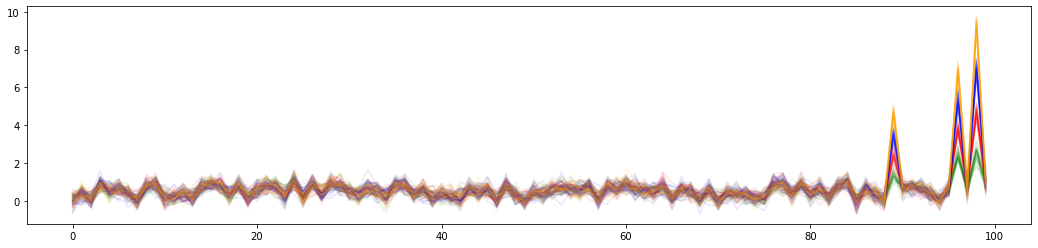

,RKT_Ridge,CST_Ridge,CST_RF
0,0.832(+/- 0.063),0.552(+/- 0.065),0.770(+/- 0.115)


In [11]:
def make_same_timestamps_diff_values(n_samples=100, n_timestamps=100, n_locs=3,
                                     n_classes=4, scale_diff=1, noise_coef=0.25,
                                     shape_coef=0.5):
    """
    This function generate a random dataset in which classes are discriminated only by value
    at the same specific locations for all classes.
    """
    X, y = _init_dataset(n_samples, n_timestamps, n_classes)
    base_data = np.random.rand(n_timestamps)
    locs = np.random.choice(range(n_timestamps), n_locs, replace=False)
    base_values = np.random.uniform(
        low=shape_coef, high=shape_coef*5, size=(n_locs))
    for i in range(n_samples):
        noise = np.random.normal(0, noise_coef, n_timestamps)
        X[i, 0] = base_data + noise
        X[i, 0, locs] += (base_values)*((1+y[i])*scale_diff)
    return X, y

X, y = make_same_timestamps_diff_values()
plt.figure(figsize=(18,4))
for i in range(X.shape[0]):
    plt.plot(X[i, 0], c=color_dict[y[i]], alpha=0.1)
plt.show()

cv_all(X, y)

## Same timestamps different patterns

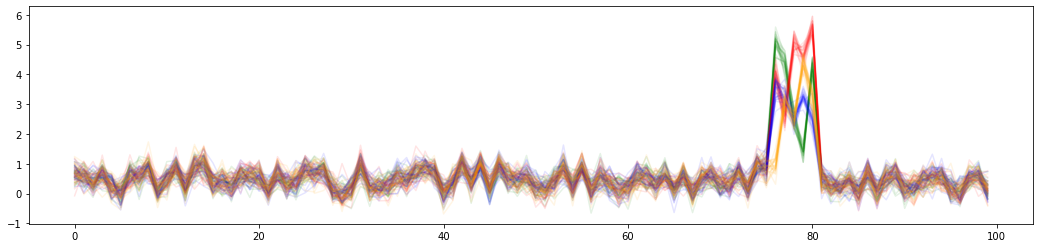

,RKT_Ridge,CST_Ridge,CST_RF
0,1.0(+/- 0.0),1.0(+/- 0.0),1.0(+/- 0.0)


In [4]:
def make_same_timestamps_diff_pattern(n_samples=100, n_timestamps=100, pattern_len=5,
                                      n_classes=4, noise_coef=0.25, shape_coef=0.5):
    X, y = _init_dataset(n_samples, n_timestamps, n_classes)
    base_data = np.random.rand(n_timestamps)
    loc = np.random.choice(range(n_timestamps-pattern_len))
    base_values = [np.random.uniform(
        low=shape_coef, high=shape_coef*10, size=(pattern_len)) for i in np.unique(y)]
    for i in range(n_samples):
        noise = np.random.normal(0, noise_coef, n_timestamps)
        X[i, 0] = base_data + noise
        X[i, 0, loc:loc+pattern_len] += base_values[y[i]]
    return X, y

X, y = make_same_timestamps_diff_pattern()
plt.figure(figsize=(18,4))
for i in range(X.shape[0]):
    plt.plot(X[i, 0], c=color_dict[y[i]], alpha=0.1)
plt.show()

cv_all(X, y)

## Different timestamps different patterns

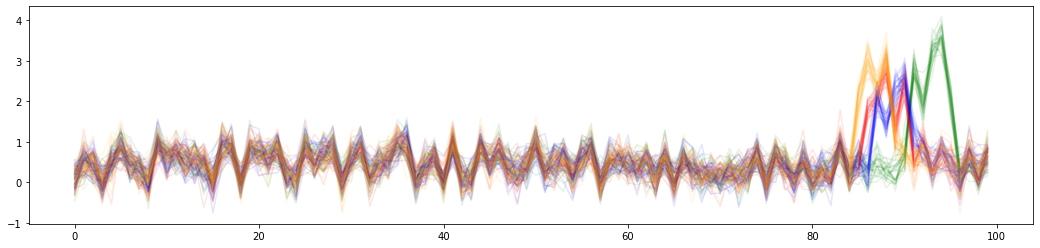

,RKT_Ridge,CST_Ridge,CST_RF
0,0.989(+/- 0.020),1.0(+/- 0.0),1.0(+/- 0.0)


In [5]:
def make_diff_timestamps_diff_pattern(n_samples=100, n_timestamps=100, pattern_len=5,
                                      n_classes=4, noise_coef=0.25, shape_coef=0.5):
    X, y = _init_dataset(n_samples, n_timestamps, n_classes)
    base_data = np.random.rand(n_timestamps)
    loc = np.random.choice(range(n_timestamps-pattern_len),
                           np.unique(y).shape[0], replace=False)
    base_values = [np.random.uniform(
        low=shape_coef, high=shape_coef*6, size=(pattern_len)) for i in np.unique(y)]
    for i in range(n_samples):
        noise = np.random.normal(0, noise_coef, n_timestamps)
        X[i, 0] = base_data + noise
        X[i, 0, loc[y[i]]:loc[y[i]]+pattern_len] += base_values[y[i]]
    return X, y

X, y = make_diff_timestamps_diff_pattern()
plt.figure(figsize=(18,4))
for i in range(X.shape[0]):
    plt.plot(X[i, 0], c=color_dict[y[i]], alpha=0.1)
plt.show()

cv_all(X, y)

## Different timestamps same pattern

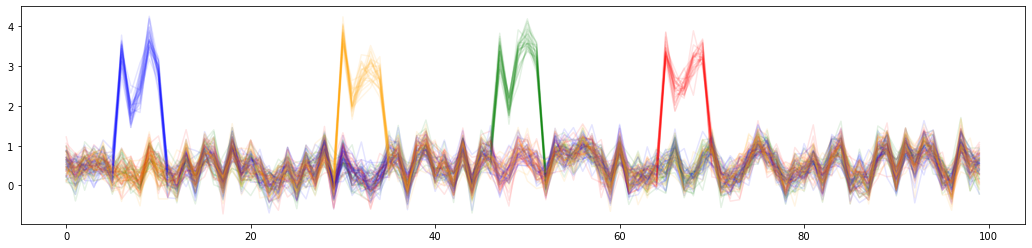

,RKT_Ridge,CST_Ridge,CST_RF
0,1.0(+/- 0.0),1.0(+/- 0.0),1.0(+/- 0.0)


In [6]:
def make_diff_timestamps_same_pattern(n_samples=100, n_timestamps=100, pattern_len=5,
                                      n_classes=4, noise_coef=0.25, shape_coef=0.5):
    X, y = _init_dataset(n_samples, n_timestamps, n_classes)
    base_data = np.random.rand(n_timestamps)
    loc = np.random.choice(range(n_timestamps-pattern_len),
                           np.unique(y).shape[0], replace=False)
    base_values = np.random.uniform(
        low=shape_coef, high=shape_coef*6, size=(pattern_len))
    for i in range(n_samples):
        noise = np.random.normal(0, noise_coef, n_timestamps)
        X[i,0] = base_data + noise
        X[i, 0, loc[y[i]]:loc[y[i]]+pattern_len] += base_values
    return X, y

X, y = make_diff_timestamps_same_pattern()
plt.figure(figsize=(18,4))
for i in range(X.shape[0]):
    plt.plot(X[i, 0], c=color_dict[y[i]], alpha=0.1)
plt.show()

cv_all(X, y)

## Shift different patterns

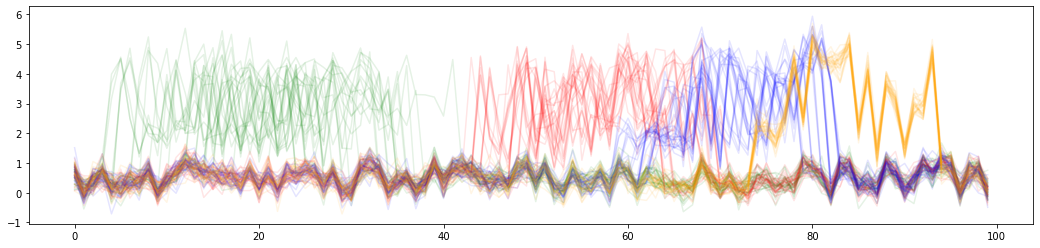

,RKT_Ridge,CST_Ridge,CST_RF
0,1.0(+/- 0.0),1.0(+/- 0.0),1.0(+/- 0.0)


In [7]:
def make_shift_different_pattern(n_samples=100, n_timestamps=100, pattern_len=20,
                                 n_classes=4, noise_coef=0.25, shape_coef=0.75, shift_coef=0.25):
    X, y = _init_dataset(n_samples, n_timestamps, n_classes)
    base_data = np.random.rand(n_timestamps)
    loc = np.random.choice(range(n_timestamps-pattern_len),
                           np.unique(y).shape[0], replace=False)
    base_values = [np.random.uniform(
        low=shape_coef, high=shape_coef*6, size=(pattern_len)) for i in np.unique(y)]
    for i in range(n_samples):
        noise = np.random.normal(0, noise_coef, n_timestamps)
        X[i, 0] = base_data + noise
        l = loc[y[i]]
        # TODO bug sometimes empty
        l += np.random.choice(range(int((n_timestamps -
                                         (pattern_len+l))*shift_coef)))
        X[i, 0, l:l+pattern_len] += base_values[y[i]]
    return X, y

X, y = make_shift_different_pattern()
plt.figure(figsize=(18,4))
for i in range(X.shape[0]):
    plt.plot(X[i, 0], c=color_dict[y[i]], alpha=0.1)
plt.show()

cv_all(X, y)